# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-17 13:26 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-17 13:26 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-17 13:26 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-17 13:26 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-17 13:26 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-17 13:26 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-17 13:27 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-17 13:27 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-17 13:27 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [5]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [8]:
ratings = sc.textFile(RATINGS_PATH)

In [9]:
%%time
ratings.take(5)

CPU times: user 12.8 ms, sys: 0 ns, total: 12.8 ms
Wall time: 2.79 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [10]:
ratings.getNumPartitions()

5

In [287]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [12]:
ratings.count()

25000095

Количество пользователей

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 33.3 ms, sys: 1.27 ms, total: 34.6 ms
Wall time: 1min 54s


162541

Сохраним датасет в память

In [14]:
ratings = ratings.persist()

In [15]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 40.4 ms, sys: 1.07 ms, total: 41.5 ms
Wall time: 3min 10s


162541

Количество фильмов

In [16]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 28.6 ms, sys: 5.57 ms, total: 34.2 ms
Wall time: 58.3 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [288]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [289]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .take(10)

[(196609, (3.5, ['196609', 'Bigfoot The Movie (2015)'])),
 (169302, (2.9166666666666665, ['169302', 'Everybody Loves Somebody (2017)'])),
 (147462, (3.0, ['147462', 'Dead Creatures (2001)'])),
 (7, (3.3636663369601054, ['7', 'Sabrina (1995)'])),
 (131082, (2.625, ['131082', 'Playground (2009)'])),
 (79191, (3.34, ['79191', 'Roadracers (1994)'])),
 (32781, (3.2884615384615383, ['32781', 'Hawaii (1966)'])),
 (14, (3.4234888364494465, ['14', 'Nixon (1995)'])),
 (180243, (2.1666666666666665, ['180243', 'Rejection (2009)'])),
 (32788, (3.630434782608696, ['32788', 'Loners (Samotári) (2000)']))]

In [290]:
movies.take(5)

[(1, ['1', 'Toy Story (1995)']),
 (2, ['2', 'Jumanji (1995)']),
 (3, ['3', 'Grumpier Old Men (1995)']),
 (4, ['4', 'Waiting to Exhale (1995)']),
 (5, ['5', 'Father of the Bride Part II (1995)'])]

In [292]:
movie_avg_rating.take(5)

[(32770, 3.5727272727272728),
 (5, 3.0584343520573674),
 (196615, 3.5),
 (131080, 3.0),
 (10, 3.42145763311516)]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [19]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [20]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-16 21:06 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      59125 2021-02-16 21:06 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112200 2021-02-16 21:06 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131273 2021-02-16 21:06 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114154 2021-02-16 21:06 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133702 2021-02-16 21:06 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117718 2021-02-16 21:06 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143222 2021-02-16 21:06 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132134 2021-02-16 21:06 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167806 2021-02-16 21:06 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [21]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [22]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [23]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

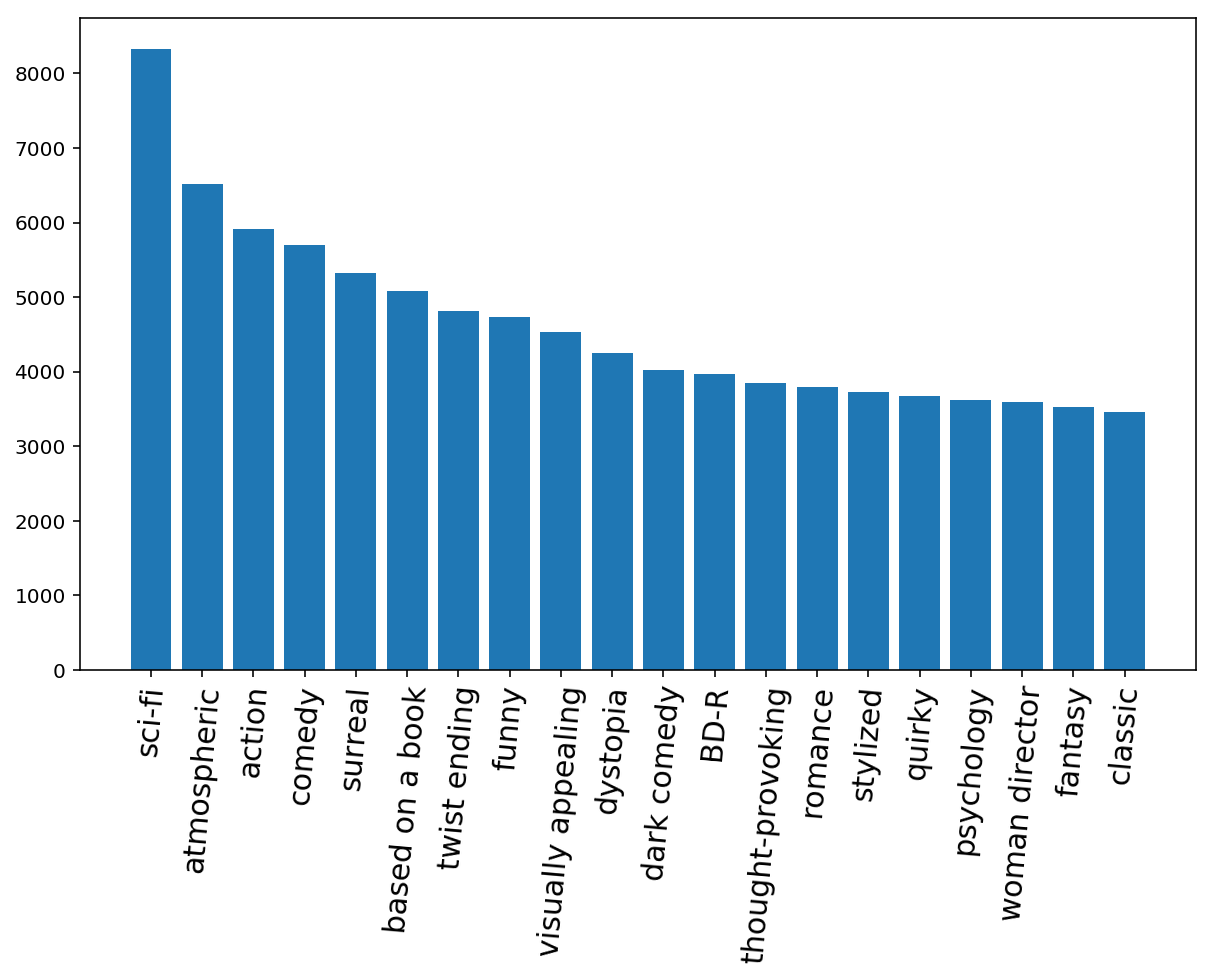

In [24]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [16]:
ratings = sc.textFile(RATINGS_PATH)

In [17]:
%%time
ratings.take(5)

CPU times: user 6.39 ms, sys: 0 ns, total: 6.39 ms
Wall time: 182 ms


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [18]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [19]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [20]:
movies.take(5)

[(1, ['1', 'Toy Story (1995)']),
 (2, ['2', 'Jumanji (1995)']),
 (3, ['3', 'Grumpier Old Men (1995)']),
 (4, ['4', 'Waiting to Exhale (1995)']),
 (5, ['5', 'Father of the Bride Part II (1995)'])]

In [21]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [26]:
ratings_count = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)

In [27]:
ratings_count \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1], ascending=False) \
    .take(10)

[(356, (81491, ['356', 'Forrest Gump (1994)'])),
 (318, (81482, ['318', '"Shawshank Redemption'])),
 (296, (79672, ['296', 'Pulp Fiction (1994)'])),
 (593, (74127, ['593', '"Silence of the Lambs'])),
 (2571, (72674, ['2571', '"Matrix'])),
 (260, (68717, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (480, (64144, ['480', 'Jurassic Park (1993)'])),
 (527, (60411, ['527', "Schindler's List (1993)"])),
 (110, (59184, ['110', 'Braveheart (1995)'])),
 (2959, (58773, ['2959', 'Fight Club (1999)']))]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [58]:
ratings = sc.textFile(RATINGS_PATH)
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [59]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .filter(lambda arr: arr[2] == '5.0') \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [60]:
ratings5_count = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)


In [61]:
ratings5_count \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1], ascending=False) \
    .take(10)

[(318, (39553, ['318', '"Shawshank Redemption'])),
 (296, (32169, ['296', 'Pulp Fiction (1994)'])),
 (356, (25918, ['356', 'Forrest Gump (1994)'])),
 (260, (25804, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (2571, (25482, ['2571', '"Matrix'])),
 (527, (24853, ['527', "Schindler's List (1993)"])),
 (593, (24801, ['593', '"Silence of the Lambs'])),
 (858, (24418, ['858', '"Godfather'])),
 (50, (21585, ['50', '"Usual Suspects'])),
 (2959, (21486, ['2959', 'Fight Club (1999)']))]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [81]:
ratings = sc.textFile(RATINGS_PATH)
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [82]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [78]:
movies = sc.textFile(MOVIES_PATH)

In [84]:
movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

ratings_count = movie_avg_rating \
    .map(lambda arg: (arg[1], 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda key_value: key_value[0], ascending=False)\
    .collect()

len(ratings_count)

12972

In [128]:
rating_count = sorted(ratings_count, key=lambda tag_count: tag_count[0])

In [129]:
rating_count[:10]

[(0.5, 543),
 (0.5833333333333334, 1),
 (0.6, 2),
 (0.625, 5),
 (0.6666666666666666, 12),
 (0.6785714285714286, 1),
 (0.7, 4),
 (0.75, 74),
 (0.8, 3),
 (0.8333333333333334, 18)]

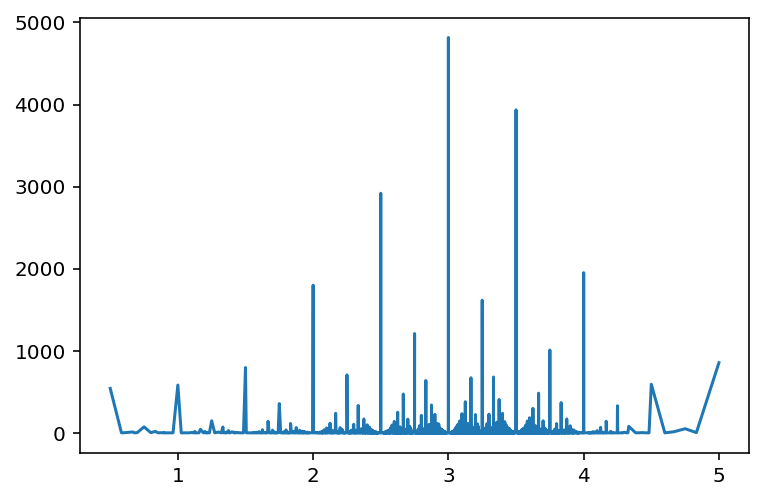

In [130]:
keys, values = zip(*rating_count)

# f, ax = plt.subplots(figsize=(10, 6))
# plt.xticks(rotation=85, fontsize=15)
# plt.bar(keys, values, align="center")
# plt.show()
plt.plot(keys, values)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [97]:
ratings = sc.textFile(RATINGS_PATH)
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [98]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [99]:
number_ratings = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .map(lambda arg: (arg[1], 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()

len(number_ratings)

3820

In [115]:
number_ratings[0]

(12290, 1)

In [119]:
number_ratings = sorted(number_ratings, key=lambda tag_count: tag_count[1])

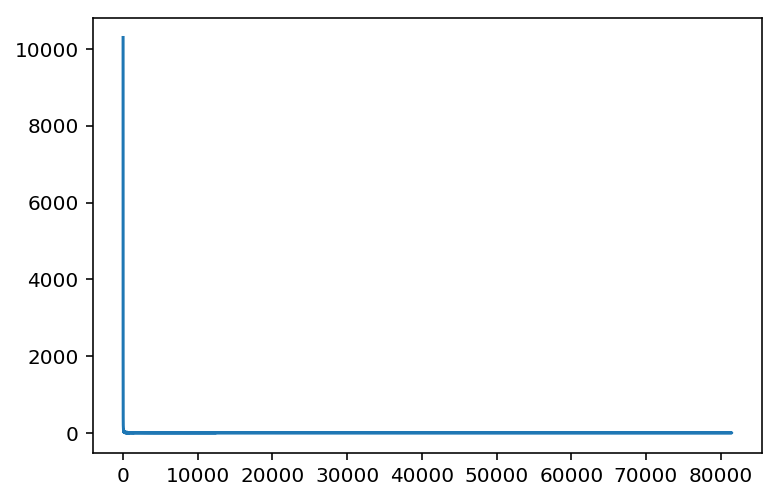

In [123]:
keys, values = zip(*number_ratings)

# f, ax = plt.subplots()
# plt.bar(keys, values)
plt.plot(keys, values)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [172]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [173]:
genresList = ["Action", "Adventure", "Animation", "Children's", "Comdey", 
             "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", 
             "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
             "Thriller", "War", "Western", "(no genres listed)"]

In [174]:
movies = movies \
    .map(lambda s: s.split(',')[2]) \
    .filter(lambda arr: arr != 'genresList')\
    .map(lambda s: s.split('|'))\
    .map(lambda genre: (genre[0], 1))\
    .filter(lambda arr: arr[0] in genresList) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()

In [177]:
movie = sorted(movies, key=lambda tag_count: tag_count[1])

In [178]:
movie[:20]

[('Film-Noir', 28),
 ('Musical', 81),
 ('War', 90),
 ('Fantasy', 314),
 ('Romance', 364),
 ('Mystery', 366),
 ('Sci-Fi', 472),
 ('Western', 486),
 ('Thriller', 860),
 ('Animation', 1941),
 ('Adventure', 2093),
 ('Crime', 2620),
 ('Horror', 3105),
 ('Documentary', 4727),
 ('(no genres listed)', 4913),
 ('Action', 6678),
 ('Drama', 13156)]

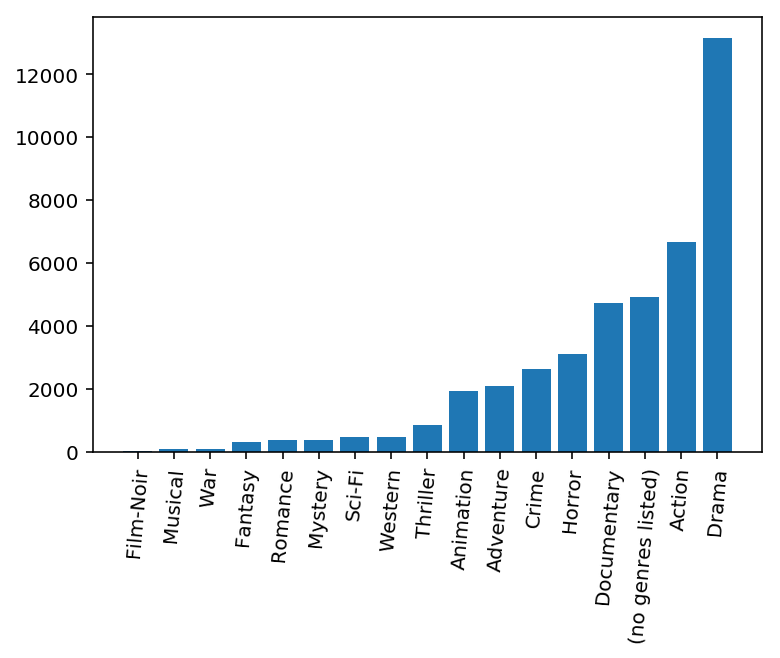

In [182]:
keys, values = zip(*movie)

f, ax = plt.subplots()
plt.bar(keys, values)
# plt.plot(keys, values)
plt.xticks(rotation=85)
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [191]:
import json

In [185]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')

In [189]:
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [294]:
ratings = sc.textFile(RATINGS_PATH)
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [333]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [334]:
links = sc.textFile(LINKS_PATH)
links.take(5)

['movieId,imdbId,tmdbId',
 '1,0114709,862',
 '2,0113497,8844',
 '3,0113228,15602',
 '4,0114885,31357']

In [335]:
tmdb = sc.textFile(TMDB_PATH)
# tmdb = tmdb.map(json.loads)


In [336]:
tmdb = tmdb \
    .filter(lambda s: '"id": 31, "name": "Tom Hanks"' in s) \
    .map(json.loads) \
    .map(lambda arg: arg['id']) \
    .take(100000)


movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))


links = links \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arg: (arg[0], arg[2])) \
    .keyBy(lambda arr: int(arr[0])) \
    .filter(lambda arg: int(arg[1][1]) in tmdb) \
    .map(lambda arg: (arg[0], arg[0]))


links \
    .join(movies) \
    .take(5)
#     .filter(lambda arg: arg[1][1] in tmdb) \
#     .join(movies) \
#     .take(100000)



Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 327.0 failed 4 times, most recent failure: Lost task 0.3 in stage 327.0 (TID 826, quickstart.cloudera): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/worker.py", line 111, in main
    process()
  File "/usr/lib/spark/python/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/lib/spark/python/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "<ipython-input-336-86352f68e2c2>", line 19, in <lambda>
ValueError: invalid literal for int() with base 10: ''

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:129)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:125)
	at org.apache.spark.InterruptibleIterator.next(InterruptibleIterator.scala:43)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:280)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1766)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:239)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1843)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1856)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1869)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor66.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/worker.py", line 111, in main
    process()
  File "/usr/lib/spark/python/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/lib/spark/python/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "<ipython-input-336-86352f68e2c2>", line 19, in <lambda>
ValueError: invalid literal for int() with base 10: ''

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:129)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:125)
	at org.apache.spark.InterruptibleIterator.next(InterruptibleIterator.scala:43)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:280)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1766)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:239)


In [337]:
links.take(5)

[(1, 1), (150, 150), (356, 356), (508, 508), (539, 539)]

In [338]:
movies.take(5)

[(1, ['1', 'Toy Story (1995)']),
 (2, ['2', 'Jumanji (1995)']),
 (3, ['3', 'Grumpier Old Men (1995)']),
 (4, ['4', 'Waiting to Exhale (1995)']),
 (5, ['5', 'Father of the Bride Part II (1995)'])]

In [268]:
tmdb

[862,
 568,
 13,
 9800,
 858,
 32562,
 9591,
 857,
 11974,
 2619,
 10466,
 29968,
 9489,
 2280,
 56235,
 863,
 9586,
 497,
 11287,
 19259,
 12309,
 40820,
 8358,
 6951,
 65262,
 2565,
 4147,
 640,
 20763,
 10023,
 5516,
 594,
 10905,
 5255,
 591,
 920,
 35,
 6538,
 16279,
 13448,
 5707,
 10193,
 15302,
 59861,
 64685,
 574379,
 83542,
 109424,
 213121,
 140823,
 170039,
 77887,
 82424,
 37641,
 130925,
 256835,
 253639,
 339988,
 296098,
 356325,
 270010,
 87061,
 363676,
 207932,
 305642,
 27348,
 446354,
 35866,
 467062,
 414792,
 504561,
 30172,
 252451,
 558912,
 550600,
 301528]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################